In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pre Filtered Treated(only ids that they have 6 months of history from their registered date) and controls with the HasPast flag

In [4]:
%%time
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle('tempHybridSelectionMoreData/random.p')

CPU times: user 6.98 s, sys: 16 s, total: 23 s
Wall time: 1min


In [5]:
pmpm.head(2)

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   

   CC_OSTEOPOROSIS  CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  LOB  PREGNANCY  IP_BIN  ER_BIN  ACUTE  IP_C  ER_C  ACUTE_C  IP_BIN6  ER_BIN6  ACUTE6  IP_BIN2  ER_BIN2  ACUTE2  
0              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0.0     0.0  
1              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use hier matching as our matching function</div>

In [6]:
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
controls2.shape, controls.shape

In [7]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [8]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = all_columns2
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched1, matched_data0 = matched_population(treated2.copy(), 
                                           controls2.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" = 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)
"""


Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:269017 before they were:299160
IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None
There were no matches for 0 out of 1367 patients
CPU times: user 49min 41s, sys: 37min 35s, total: 1h 27min 16s
Wall time: 56min 16s


'\n#columns_to_match = columns_to_match + [\'IP_BIN2\', \'ER_BIN2\']\npropensity_func_args = {\'match_on\':columns_to_match, \'neighbors_per_treated\': 5, \'onset\': "CC_DIABETES", "onset_val" = 1}\nmatched0, matched_data0 = matched_population(treated2.copy(), \n                                           controls.copy(),\n                                           propensity_func, \n                                           propensity_func_args)\n'

### Save data

In [10]:
Path('./tempNNhierALLTheory').mkdir(exist_ok = True)
p1 = 'tempNNhierALLTheory/'
#matched_data1.to_pickle(p+'match1.p')
treated2.to_pickle(p1+'treated2.p')
p = './tempNNhierAgglotheory/'



### Load matched data

with open(p+'matchesPast.p', 'rb') as handle:
    matched1 = pickle.load(handle)


In [11]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [12]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [13]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Get For each group treated ids and matched controls

In [14]:
controls_all =  pd.DataFrame()
matched_data0 = pd.DataFrame()
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

In [15]:
%%time
counter = 0

for (key, month), val in matched1.items():
    val['RD'] = val.MYR
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)    
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    matched_data0 = pd.concat((matched_data0, new_dat2), ignore_index = True)
    controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    counter += 1
    

CPU times: user 6min 55s, sys: 1min 33s, total: 8min 29s
Wall time: 8min 29s


### Save controls Needed for Diff and Diff

In [16]:
matched_data0.PERS_ID.unique().shape,treated2.PERS_ID.unique().shape

In [17]:
controls_all.to_pickle(p1+'controls_all.p')
matched_data0.to_pickle(p1+'matched.p')

### Start Stats Analysis

In [18]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [19]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [20]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated2, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0, all_columns, return_array = True)

CPU times: user 3.5 s, sys: 65.3 ms, total: 3.57 s
Wall time: 3.57 s


### Stats First Month(General Pop and Random)

In [21]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 29s, sys: 7.66 s, total: 2min 36s
Wall time: 2min 36s


In [22]:
%%time
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 29.8 ms, sys: 0 ns, total: 29.8 ms
Wall time: 29.4 ms


## Statistics on matching date

In [23]:
conds_first.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.738           50.799  -0.166  0.868             44.311   47.606
ALLOW_AMT        712.070          589.285   2.305  0.021           1065.926  648.803
MBR_GNDR           0.212            0.212   0.016  0.987              0.443    0.431
CC_TOBACCO         0.061            0.070  -1.107  0.268              0.074    0.098
CC_PRESSURE        0.001            0.002  -0.635  0.526              0.007    0.007
CC_OBESITY         0.499            0.499  -0.030  0.976              0.109    0.228
CC_HYPERTENSION    0.342            0.349  -0.475  0.635              0.208    0.249
CC_HYPOTHYROID     0.101            0.090   1.287  0.198              0.047    0.063
CC_DX_CNT          2.912            2.731   2.847  0.004              1.824    2.344
ACUTE2             0.040            0.031   1.447  0.148              0.063    0.052
ACUTE6             0.116            0.110   0.511  0.609              0.063    0.153
IP_BIN6            0.030            0.027   0.638  0.524              0.021    0.047
ER_BIN6            0.091            0.088   0.355  0.723              0.047    0.116
LOB                0.955            0.956  -0.183  0.855              0.756    0.788

In [24]:
full_first

Treated                    Matched Controls                      Test-TC           General Population                         Test-TG                    Random                       Test-TR              
                       mean          std count             mean          std count    t-stat      pval               mean          std   count     t-stat          pval        mean          std count     t-stat          pval
AGE_AT_MIDMONTH   50.738113    12.484023  1367        50.799473    12.491336  6827 -0.165795  0.868323          44.310976    20.053585  356446  11.840960  2.430548e-32   47.606399    19.811819  7876   5.652741  1.625984e-08
ALLOW_AMT        712.070227  2240.844303  1367       589.284605  1695.034229  6827  2.305188  0.021181        1065.926022  6933.418650  356446  -1.886582  5.921741e-02  648.802692  3166.090228  7876   0.708646  4.785620e-01
MBR_GNDR           0.212143     0.408975  1367         0.211953     0.408721  6827  0.015756  0.987429           0.442749     0.496712  356446 -17.142918  7.544162e-66    0.431056     0.495255  7876 -15.453632  3.291804e-53
CC_TOBACCO         0.061448     0.240239  1367         0.069723     0.254699  6827 -1.106650  0.268478           0.074202     0.262100  356446  -1.796182  7.246636e-02    0.098400     0.297874  7876  -4.347638  1.390855e-05
CC_PRESSURE        0.001463     0.038236  1367         0.002344     0.048358  6827 -0.634696  0.525644           0.007390     0.085645  356446  -2.557523  1.054246e-02    0.006602     0.080991  7876  -2.301931  2.136122e-02
CC_OBESITY         0.498903     0.500182  1367         0.499341     0.500036  6827 -0.029570  0.976411           0.108841     0.311440  356446  46.079325  0.000000e+00    0.228035     0.419592  7876  21.377224  5.296178e-99
CC_HYPERTENSION    0.342356     0.474672  1367         0.349055     0.476706  6827 -0.474640  0.635056           0.207717     0.405674  356446  12.238795  1.959621e-34    0.249365     0.432673  7876   7.227219  5.320844e-13
CC_HYPOTHYROID     0.100951     0.301374  1367         0.089937     0.286112  6827  1.287444  0.197976           0.047300     0.212281  356446   9.308456  1.304020e-20    0.063484     0.243847  7876   5.050777  4.484259e-07
CC_DX_CNT          2.912217     2.261374  1367         2.730628     2.130232  6827  2.846848  0.004426           1.824419     2.412274  356446  16.644659  3.491967e-62    2.343702     2.439688  7876   8.037223  1.031819e-15
ACUTE2             0.039503     0.209348  1367         0.031493     0.182050  6827  1.446507  0.148073           0.063258     0.243426  356446  -3.602975  3.146389e-04    0.051549     0.237733  7876  -1.758856  7.863515e-02
ACUTE6             0.115582     0.422412  1367         0.109565     0.392212  6827  0.510936  0.609409           0.063258     0.243426  356446   7.901748  2.757940e-15    0.153377     0.475791  7876  -2.754639  5.887196e-03
IP_BIN6            0.029993     0.205649  1367         0.026512     0.179608  6827  0.637622  0.523737           0.020587     0.141996  356446   2.439382  1.471288e-02    0.046851     0.263725  7876  -2.247805  2.461213e-02
ER_BIN6            0.091441     0.368577  1367         0.087740     0.348796  6827  0.354687  0.722833           0.047286     0.212251  356446   7.647468  2.054816e-14    0.116176     0.402957  7876  -2.120727  3.397134e-02
LOB                0.954645     0.208157  1367         0.955764     0.205634  6827 -0.183217  0.854632           0.755775     0.429627  356446  17.106694  1.405094e-65    0.787836     0.408866  7876  14.755466  1.014600e-48

### Statistics Over all dates (treated, controls)

In [25]:
%%time
tr_desc0A = treated2[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

CPU times: user 671 ms, sys: 1.02 ms, total: 672 ms
Wall time: 671 ms


### Statistics Over all dates (general population, Random)

In [26]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 29.2 s, sys: 2.42 s, total: 31.6 s
Wall time: 31.6 s


In [27]:
%%time
conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 28.1 ms, sys: 561 µs, total: 28.7 ms
Wall time: 26.9 ms


In [28]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   51.079           51.454  -4.141  0.000             50.379   50.236
ALLOW_AMT        812.538          742.433   2.561  0.010            857.856  706.609
MBR_GNDR           0.196            0.198  -0.721  0.471              0.433    0.429
CC_TOBACCO         0.064            0.079  -7.718  0.000              0.102    0.100
CC_PRESSURE        0.003            0.003  -0.577  0.564              0.013    0.008
CC_OBESITY         0.533            0.506   7.417  0.000              0.255    0.286
CC_HYPERTENSION    0.332            0.342  -2.879  0.004              0.329    0.300
CC_HYPOTHYROID     0.098            0.094   1.759  0.079              0.078    0.075
CC_DX_CNT          3.049            2.911   8.432  0.000              2.955    2.759
ACUTE2             0.032            0.034  -1.372  0.170              0.060    0.050
ACUTE6             0.101            0.104  -1.236  0.216              0.168    0.150
IP_BIN6            0.026            0.030  -2.502  0.012              0.055    0.049
ER_BIN6            0.079            0.079  -0.110  0.913              0.122    0.111
LOB                0.955            0.951   2.726  0.006              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [29]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [30]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [31]:
base_path = './results/'+p1
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [32]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [33]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

In [34]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

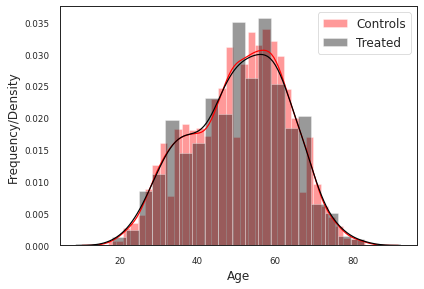

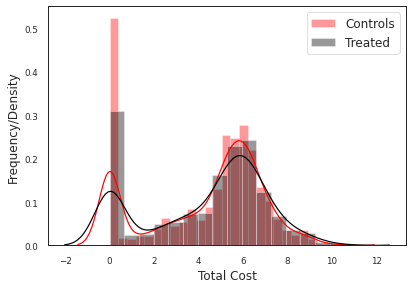

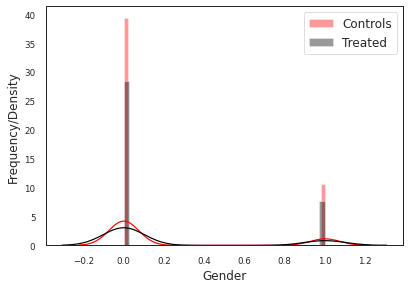

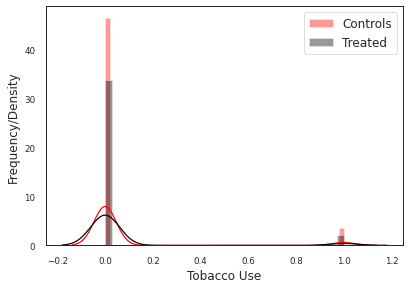

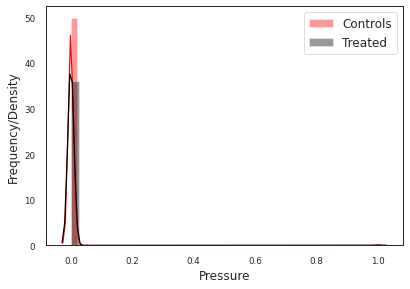

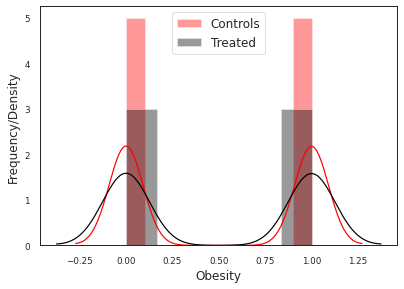

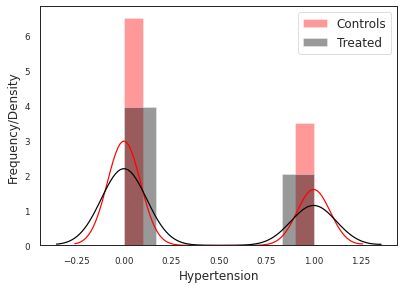

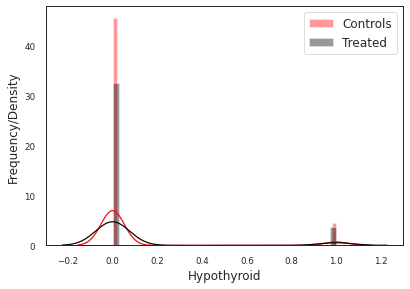

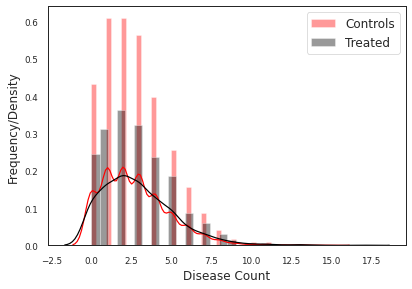

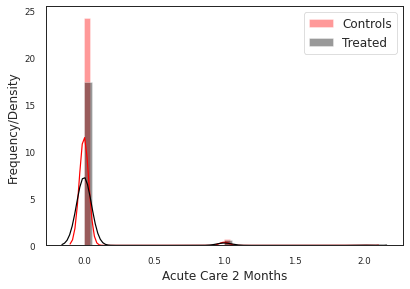

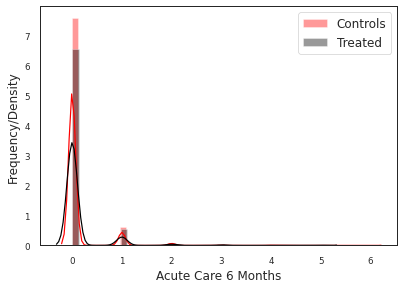

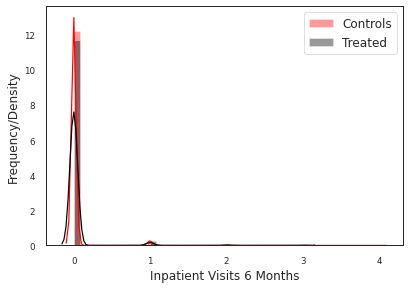

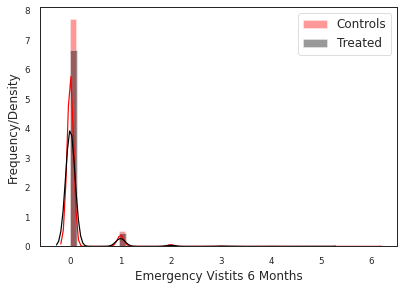

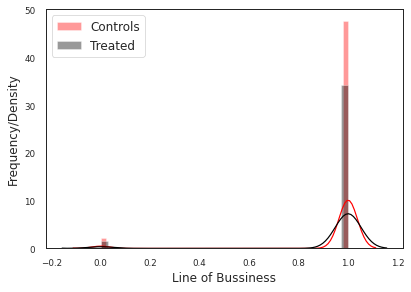

In [35]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [36]:
arrays = [conds_first, full_first, conds_firstAllCols, full_firstAllCols,
         conds, full, conds_AllCols, full_AllCols]
names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']
save_arrays2(arrays, names, base_path+'tables/stats/')